<a href="https://colab.research.google.com/github/fmejias/CienciasDeLosDatosTEC/blob/master/AprendizajeAutomatico/TP0/TP0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje Automático
# Trabajo práctico 0

- Professor: M.Sc.Saul Calderon.

- Students: 
    - María Auxiliadora Mora, Instituto Tecnológico de Costa Rica  
    - Felipe Alberto Mejías Loría, Instituto Tecnológico de Costa Rica. 

- July 06th, 2019   

In [0]:
# Libraries required for the exercises
from __future__ import print_function
import torch as torch
import numpy as np
import math
from sympy import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from numpy import linalg as linalg
from skimage import color
from functools import reduce
import operator
import statistics
from cycler import cycler

# Pandas library for reading csvs
from pandas import read_csv

# 1) La convolución en una dimensión (100 puntos)



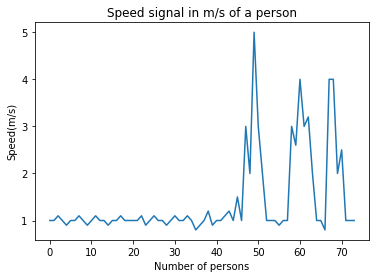

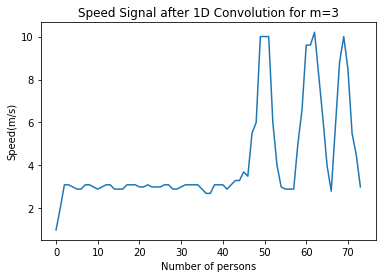

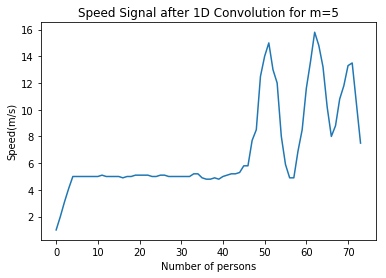


Resultados: 

- Como se observa en ambas gráficas, entre mayor es el valor de m más se suaviza la señal resultante
- Un valor de m muy grande provoca que la señal resultante se parezca a una recta



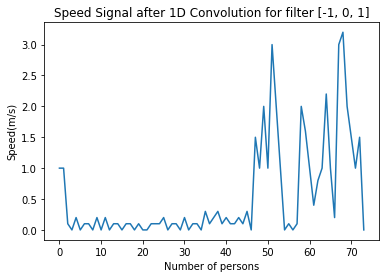

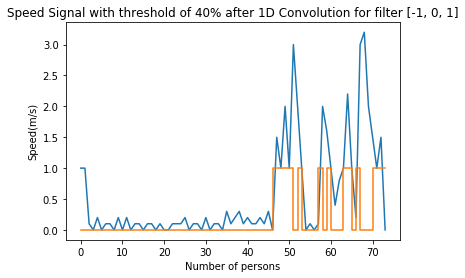

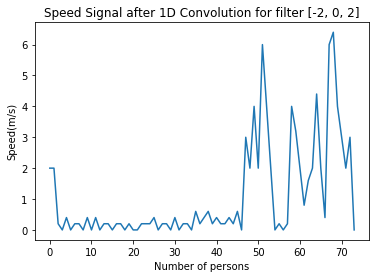

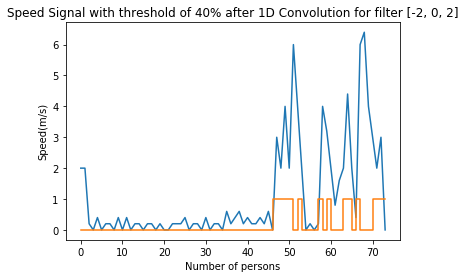


Resultados: 

- Como se observa en ambas gráficas, entre mayor es el valor de a mayor es la magnitud de la señal
- La salida resultante solamente varía en magnitud debido al valor que se le asigne a a.


Exercise 1.4:

Plot Original Oscilation Signal


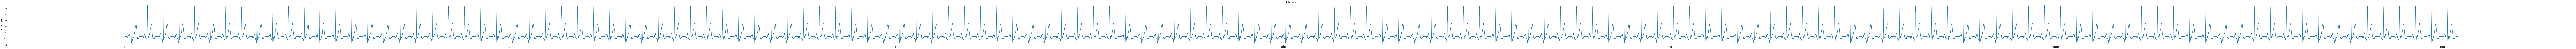


Plot Autocorrelation from Oscilation Signal


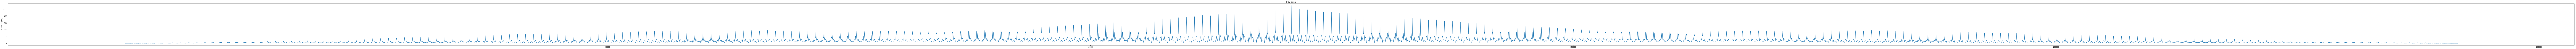

In [73]:
def oneDimensionConvolution():  
  # Set CSV Path
  speedDatasetPath = 'https://raw.githubusercontent.com/fmejias/CienciasDeLosDatosTEC/master/AprendizajeAutomatico/TP0/speed.csv'
  oscilationsDatasetPath = 'https://raw.githubusercontent.com/fmejias/CienciasDeLosDatosTEC/master/AprendizajeAutomatico/TP0/ecg1.csv'
    
  # Read the dataset from csv
  speedDataset = read_csv(speedDatasetPath, header=None)
  oscilationsDataset = read_csv(oscilationsDatasetPath, header=None)
  
  # Set number of Samples and Samples Values
  numberOfSpeedSamples = speedDataset.columns.values
  speedSampleValues = speedDataset[0:].values.tolist()[0]
  speedValuesTensor = torch.tensor(speedSampleValues)

  # Set number of Samples and Samples Values
  oscilationSampleValues = oscilationsDataset.iloc[:,0].tolist()
  numberOfOscilationSamples = oscilationsDataset.iloc[:,0].index.tolist()
  oscilationValuesTensor = torch.tensor(oscilationSampleValues)

  # Exercise 1.a
  def plotSignal(speedValues, numberOfSamples, title='Speed signal in m/s of a person'):
    """
    Graph the Speed Signal
    """
    # Plot
    plt.xlabel('Number of persons')
    plt.ylabel('Speed(m/s)')
    plt.title(title)
    plt.plot(numberOfSamples,speedValues)
    plt.show()
  
  def plotECGSignal(speedValues, numberOfSamples, title='ECG signal', markCycle=False):
    """
    Graph the Speed Signal
    """
    # Set plot variables
    plt.figure(figsize=(300,5))
    plt.ylabel('Oscilaciones(mV)')
    plt.title(title)
    
    # Plot vertical lines to mark signal cycle
    if markCycle:
      cycles = speedValues.copy()
      cycles = np.array(cycles)
      cycles[cycles >= max(cycles)*0.9] = max(cycles)
      cycles[cycles < max(cycles)] = min(cycles)
      plt.plot(numberOfSamples, cycles, linewidth=2.0, c='r')
    
    # Plot ECG Signal
    plt.plot(numberOfSamples,speedValues)
    plt.show()
  
  def calculateBinarySignal(speedValues, threshold=0.4):
    """
    Generate Binary Signal
    """
    initialEvent = False
    binarySignal = []
    maxValue = max(speedValues)
    for speedValue in speedValues:
      if speedValue >= threshold*maxValue and initialEvent == False:
        binarySignal.append(1)
        initialEvent = True
      elif speedValue <= threshold*maxValue and initialEvent == True:
        binarySignal.append(1)
        initialEvent = False
      else:
        binarySignal.append(0)
    return binarySignal
    
  def plotSignalWithThreshold(speedValues, numberOfSamples, title=''):
    """
    Graph the Speed Signal
    """
    binarySignal = calculateBinarySignal(speedValues, threshold=0.4)
  
    # Plot
    plt.xlabel('Number of persons')
    plt.ylabel('Speed(m/s)')
    plt.title(title)
    plt.plot(numberOfSamples, speedValues)
    plt.step(numberOfSamples, binarySignal)
    plt.show()

  # Exercise 1.b
  def convolucionar1D(f, g):
    gSize = list(g.size())[0]
    fSize = list(f.size())[0]
    result = torch.zeros(fSize)

    # Append zeros to filter in zero padding
    g = torch.from_numpy(np.pad(g.numpy(), (0, fSize - gSize), 'constant'))

    for index in range(1, fSize+1):
      # Split and reverse Filter: g[n-m]
      splitFilter = g[0:index]
      reversedFilter = np.flip(splitFilter.numpy(), 0).copy()

      # Append zeros to reverse filter in zero padding
      reversedTensor = torch.from_numpy(np.pad(reversedFilter, (0, fSize - gSize), 'constant'))
      
      # Dot product and append result
      dot_product = torch.dot(f[0:index], reversedTensor[0:index])
      result[index-1] = abs(dot_product)

    return result
  
  # Exercise 1.b
  def autocorrelacionar(u):
     # Calculate the cross correlation of a signal using the dot product.
     #     At each iteration the fuction fills with a zero the end of vector u (the new signal f)
     #     a removes the first element of f.
     #     Then it computes the dot product of u and the new signal f.
     # Example if u = [1,2,3,3]       
     #    Iteration 1=>  f=[1,2,3,3]
     #    Iteration 2=>  f=[2,3,3,0]
     #    Iteration 3=>  f=[3,3,0,0]
     #              4=>  f=[3,0,0,0]   
     # Parameters:
     #   u: the signal (a numpy array).
     # Returns:
     #   the cross correlation result in an array.
           
     crossCorrResult = np.zeros(u.shape[0])  # To store the cross correlation result

     signal1 = u
     #Compute the first element of the result vector. 
     crossCorrResult[0] = u.dot(signal1)     
        
     for x in range(len(u)-1):      
        signal1 = (np.pad(signal1, (0, x+1), 'constant')[1:u.shape[0]+1])
        #print("procesando",x)
        crossCorrResult[x+1] = u.dot(signal1)     

     # Return cross correlation
     a=np.flip(crossCorrResult,0)[0:u.shape[0]-1]
     crossCorrResult=np.hstack((a,crossCorrResult))
     return crossCorrResult 

    
  # Test exercise 1.1 : Plot Speed Signal
  plotSignal(speedSampleValues, numberOfSpeedSamples)
  
  # Test exercise 1.2 : Calculate 1D convolution for m = 3
  g = torch.ones(3)
  convolutionResult = convolucionar1D(speedValuesTensor, g)
  plotSignal(convolutionResult.tolist(), numberOfSpeedSamples, title='Speed Signal after 1D Convolution for m=3')
  
  # Test exercise 1.2 : Calculate 1D convolution for m = 5
  g = torch.ones(5)
  convolutionResult = convolucionar1D(speedValuesTensor, g)
  plotSignal(convolutionResult.tolist(), numberOfSpeedSamples, title='Speed Signal after 1D Convolution for m=5')
  
  # Comentar Resultados
  print("\nResultados: \n")
  print("- Como se observa en ambas gráficas, entre mayor es el valor de m más se suaviza la señal resultante")
  print("- Un valor de m muy grande provoca que la señal resultante se parezca a una recta\n")
  
  # Test exercise 1.3 : Calculate 1D convolution for a = 1
  g = [-1., 0., 1.]
  g = torch.tensor(g)
  convolutionResult = convolucionar1D(speedValuesTensor, g)
  plotSignal(convolutionResult.tolist(), numberOfSpeedSamples, title='Speed Signal after 1D Convolution for filter [-1, 0, 1]')
  
  # Test exercise 1.3 : Calculate 1D convolution for a = 1 with threshold of 0.4
  g = [-1., 0., 1.]
  g = torch.tensor(g)
  convolutionResult = convolucionar1D(speedValuesTensor, g)
  plotSignalWithThreshold(convolutionResult.tolist(), numberOfSpeedSamples, title='Speed Signal with threshold of 40% after 1D Convolution for filter [-1, 0, 1]')
  
  # Test exercise 1.3 : Calculate 1D convolution for a = 2
  g = [-2., 0., 2.]
  g = torch.tensor(g)
  convolutionResult = convolucionar1D(speedValuesTensor, g)
  plotSignal(convolutionResult.tolist(), numberOfSpeedSamples, title='Speed Signal after 1D Convolution for filter [-2, 0, 2]')
  
  # Test exercise 1.3 : Calculate 1D convolution for a = 2 with threshold of 0.4
  g = [-2., 0., 2.]
  g = torch.tensor(g)
  convolutionResult = convolucionar1D(speedValuesTensor, g)
  plotSignalWithThreshold(convolutionResult.tolist(), numberOfSpeedSamples, title='Speed Signal with threshold of 40% after 1D Convolution for filter [-2, 0, 2]')
  
  # Comentar Resultados
  print("\nResultados: \n")
  print("- Como se observa en ambas gráficas, entre mayor es el valor de a mayor es la magnitud de la señal")
  print("- La salida resultante solamente varía en magnitud debido al valor que se le asigne a a.\n")
  
  # Test exercise 1.4
  print("\nExercise 1.4:")
  print("\nPlot Original Oscilation Signal")
  plotECGSignal(oscilationSampleValues, numberOfOscilationSamples)
  u = np.array(oscilationsDataset.iloc[:,0].tolist())
  autoCorrelationResult = autocorrelacionar(u)
  print("\nPlot Autocorrelation from Oscilation Signal")
  numberOfAutocorrelationSamples = list(range(len(autoCorrelationResult.tolist())))
  plotECGSignal(autoCorrelationResult.tolist(), numberOfAutocorrelationSamples)
 

# Test exercise 1
oneDimensionConvolution()
  
  
 

# 2) La convolución en dos dimensiones (20 puntos)

Kernel 1 Output: 

Show image: 



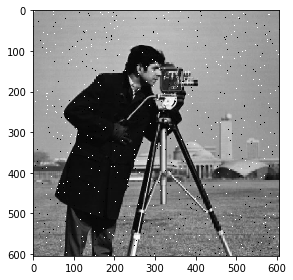


Show image: 



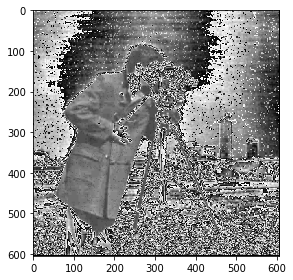

Kernel 2 Output: 

Show image: 



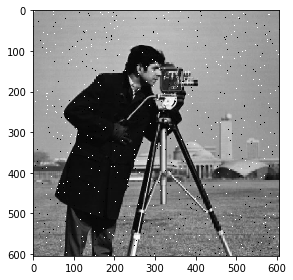


Show image: 



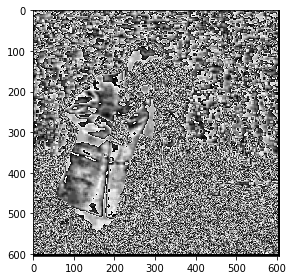

Median Filter with c=3 Output: 

Show image: 



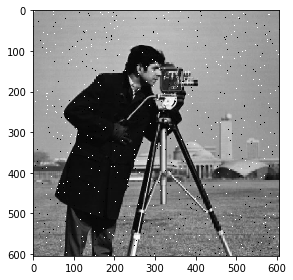


Show image: 



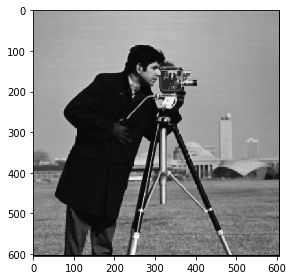

Median Filter with c=7 Output: 

Show image: 



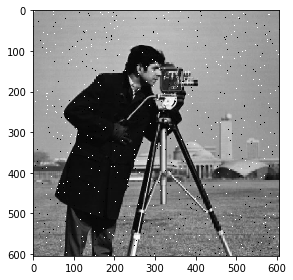


Show image: 



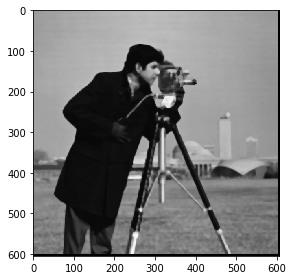

In [0]:
def showImage(image):
  print("\nShow image: \n")
  io.imshow(image) 
  io.show()
  
def convolucionar2D(kernel):
  image = io.imread('https://raw.githubusercontent.com/fmejias/CienciasDeLosDatosTEC/master/AprendizajeAutomatico/TP0/noisy.bmp', as_gray=True)
  showImage(image)
  
  # Convert the image to grayscale
  image = color.rgb2gray(image)
  
  # Flip the kernel
  kernel = np.flipud(np.fliplr(kernel))
  
  # Create matrix with zeros to save the convolution output
  convolutionResult = np.zeros_like(image)
  
  # Get the number of kernel columns and rows
  kernelColumns= np.size(kernel,1)
  kernelRows= np.size(kernel,0)
  
  # Loop over every pixel of the image
  for x in range(image.shape[1]):
      for y in range(image.shape[0]):
          if x + kernelRows <= image.shape[1] and y + kernelColumns <= image.shape[0]:
            # element-wise multiplication of the kernel and the image
            convolutionResult[y,x]=(kernel*image[y:y+kernelColumns,x:x+kernelRows]).sum()
  
  # Show filtered image
  showImage(convolutionResult)

def filtrarMedianas(c=3):
  image = io.imread('https://raw.githubusercontent.com/fmejias/CienciasDeLosDatosTEC/master/AprendizajeAutomatico/TP0/noisy.bmp', as_gray=True)
  showImage(image)
  
  # Convert the image to grayscale
  image = color.rgb2gray(image)
  
  # Create matrix with zeros to save the median filter output
  medianFilterResult = np.zeros_like(image)
  
  # Get the number of kernel columns and rows
  filterColumns= c
  filterRows= c
  
  # Loop over every pixel of the image
  for x in range(image.shape[0]):
      for y in range(image.shape[1]):
          if x + filterRows <= image.shape[0] and y + filterColumns <= image.shape[1]:
            imagePortion = image[x:x+filterRows, y:y+filterColumns]
            imagePortion = reduce(operator.concat, imagePortion.tolist())
            medianFilterResult[x, y]=statistics.median(imagePortion)
  
  # Show filtered image
  showImage(medianFilterResult)


# Test 2D Convolution
kernel1 = np.array([[1,1,1],[1,1,1],[1,1,1]])
kernel2 = np.array([[1,1,1,1,1,1,1],[1,1,1,1,1,1,1],[1,1,1,1,1,1,1],[1,1,1,1,1,1,1],[1,1,1,1,1,1,1],[1,1,1,1,1,1,1],[1,1,1,1,1,1,1]])

print("Kernel 1 Output: ")
convolucionar2D(kernel1)

print("Kernel 2 Output: ")
convolucionar2D(kernel2)

print("Median Filter with c=3 Output: ")
filtrarMedianas()

print("Median Filter with c=7 Output: ")
filtrarMedianas(c=7)